In [26]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import LFscripts as LF
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from tqdm import tqdm

In [15]:
df = pd.read_csv('catalogue.csv')
df = df[np.log10(df['OII_lum_int_calc']) < 44] # Remove outliers
df = df.reset_index(drop = True)
df['logL'] = np.log10(df['OII_lum_int_calc'])
df['err_logL'] = LF.LogError(df['OII_lum_int_calc'], df['OII_lum_err'])[0]

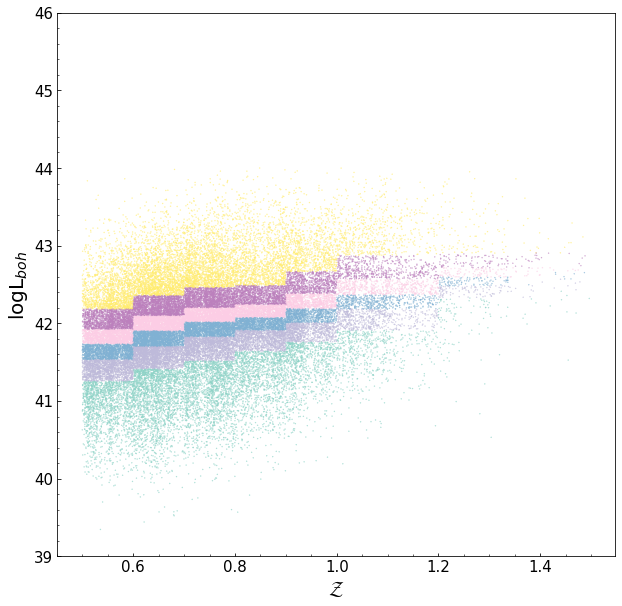

In [17]:
# Redshift-binning
redshifts = df.zspec
logL = df.logL 

redshift_bin_extremes = [0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6]
redshift_bins, redshift_digitized, redshift_bin_means, list_z_med = LF.partition_redshift(redshifts, redshift_bin_extremes)

# Luminosity-binning
no_lum_bins, bin_kind = 6, 'sspb'
luminosity_digitized, luminosity_bins = LF.partition_luminosities(logL, no_lum_bins, redshifts, redshift_bins, bin_kind)

survey_area = (24*u.deg*u.deg).to('steradian')

# This is to take a look at the logL binning (if the colors looks "right", all good)
plt.figure(figsize = (10, 10))
ax = plt.subplot(111)
ax.scatter(redshifts, logL, s = 0.1, c = luminosity_digitized, cmap = cm.Set3)
ax.set_ylim(39, 46)
ax.set_xlabel(r'$\mathcal{Z}$', size = 20)
ax.set_ylabel(r'$\log {\rm L}_{boh}}[{\rm W} {\rm Hz}^{-1}]$', size = 20)
ax.tick_params(axis='both', which='major', direction = 'in', labelsize=15)
ax.tick_params(axis='both', which='minor', direction = 'in', labelsize=8)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

In [40]:
def build_LF(df_4LF, redshifts, redshift_bin_extremes, logL, no_lum_bins, bin_kind):
    
    # Bin in z and logL
    redshift_bins, redshift_digitized, redshift_bin_means, list_z_med = LF.partition_redshift(redshifts, redshift_bin_extremes)
    luminosity_digitized, luminosity_bins = LF.partition_luminosities(logL, no_lum_bins, redshifts, redshift_bins, bin_kind)
    
    # Build dataframe for LF
    df_4LF['z_bin'] = redshift_digitized
    df_4LF['L_bin'] = luminosity_digitized
    df_4LF['z_min_4LF'] = [redshift_bins[i-1].min() for i in df_4LF.z_bin.values]
    df_4LF['z_max_bin'] = [redshift_bins[i-1].max() for i in df_4LF.z_bin.values]
    df_4LF['z_max_4LF'] = df_4LF[['z_max', 'z_max_bin']].min(axis=1)
    Vmax = (((cosmo.comoving_distance(df_4LF.z_max_4LF)**3) - (cosmo.comoving_distance(df_4LF.z_min_4LF)**3)) * (survey_area/3)).value
    Vmax *= df_4LF['weights']
    df_4LF['1/Vmax'] = 1/Vmax
    df_4LF['1/Vmax^2'] = 1/(Vmax*Vmax)
    
    # Build LF dataframe
    phi_list, errphi_list = [], []
    for z_bin_idx, z_bin in enumerate(redshift_bins):
        bin_widths = [luminosity_bins[z_bin_idx][i].ptp() for i in range(len(luminosity_bins[z_bin_idx]))]
        phi = df_4LF[df_4LF['z_bin'] == z_bin_idx+1].groupby('L_bin').sum()['1/Vmax']/bin_widths
        phi = phi.rename(str(z_bin[0])+'-'+str(z_bin[1]))
        errphi = np.sqrt(df_4LF[df_4LF['z_bin'] == z_bin_idx+1].groupby('L_bin').sum()['1/Vmax^2'])/bin_widths
        errphi = errphi.rename(str(z_bin[0])+'-'+str(z_bin[1]))
        phi_list.append(phi)
        errphi_list.append(errphi)
        
    LF_df = pd.DataFrame(phi_list).T
    eLF_df = pd.DataFrame(errphi_list).T
    logLF_df = np.log10(LF_df)
    logeLF_df= pd.DataFrame(LF.LogError(LF_df, eLF_df)[0])

    # Centers of luminosity bins (as median)
    lbin_center = np.array([[np.median(lbin) for lbin in luminosity_bins[zbin_idx]] for zbin_idx in range(len(redshift_bins))]).reshape(logLF_df.shape[::-1]).T
    lbin_center_df = pd.DataFrame(lbin_center, columns = logLF_df.columns)
    return logLF_df, logeLF_df, lbin_center_df

In [52]:
df_4LF = df[['z_max', 'z_min', 'weights']]

niter = 10 # T'ooo dico per esperienza, non c'è bisogno di farne 1000, ne bastano 10
random_redshifts = list(np.array([np.random.normal(a, b, niter) for a, b in zip(df.zspec, df.z_err)]).T)
random_logluminosity = list(np.array([np.random.normal(a, b, niter) for a, b in zip(df.logL, df.err_logL)]).T)

list_logLF_df, list_elogLF_df, list_lbin_center_df = [], [], []
for logluminosity, redshifts in tqdm(zip(random_logluminosity, random_redshifts)):
    a, b, c = build_LF(df_4LF, redshifts, redshift_bin_extremes, logL, no_lum_bins, bin_kind)
    list_logLF_df.append(a), list_elogLF_df.append(b), list_lbin_center_df.append(c)

9it [00:15,  1.71s/it]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log10
100it [02:58,  1.79s/it]


In [53]:
lbin_center_df = pd.concat(list_lbin_center_df).groupby(pd.concat(list_lbin_center_df).index).median()
elbin_center_df = pd.concat(list_lbin_center_df).groupby(pd.concat(list_lbin_center_df).index).std()

logLF_df = pd.concat(list_logLF_df).groupby(pd.concat(list_logLF_df).index).median() # 50th percentile    
elogLF_df_as_std = pd.concat(list_logLF_df).groupby(pd.concat(list_logLF_df).index).std()

elogLF_df_fromVmax = pd.concat(list_elogLF_df).groupby(pd.concat(list_elogLF_df).index).median()
elogLF_df_fromVmax = pd.DataFrame(np.array(elogLF_df_fromVmax), index = elogLF_df_as_std.index, columns = elogLF_df_as_std.columns)

elogLF_df = np.sqrt(elogLF_df_as_std**2 + elogLF_df_fromVmax**2)

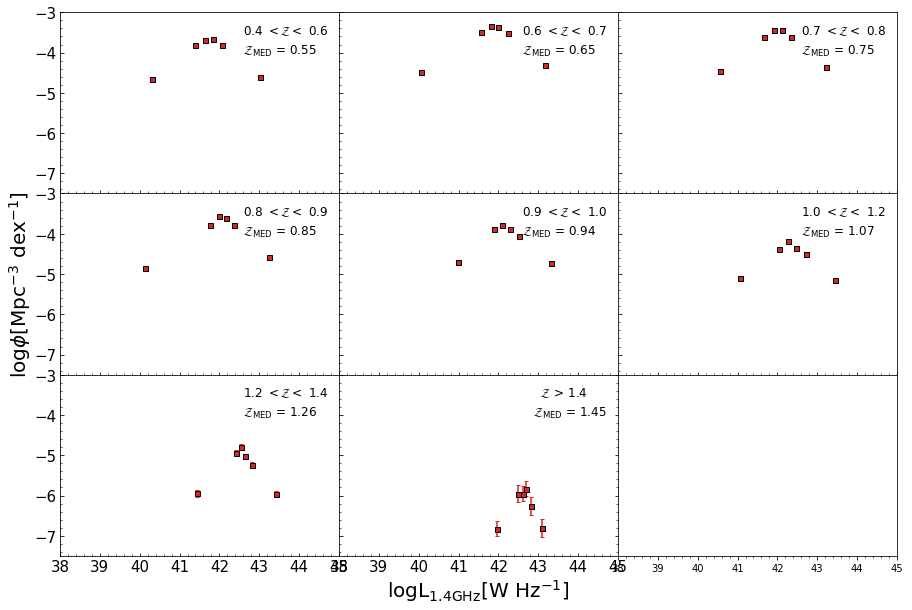

In [54]:
nx, ny = 3, 3
LFfig, axes = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(15,10))
for idx_column, (xcolumn, ycolumn, err_ycolumn) in enumerate(zip(lbin_center_df.iteritems(), logLF_df.iteritems(), elogLF_df.iteritems())):
    z_med = list_z_med[idx_column]
    # Initialize subplot
    ax = axes.flat[idx_column]
    # My LF points
    ax.errorbar(xcolumn[1].values, ycolumn[1].values, err_ycolumn[1].values, \
                    fmt = 's', ms = 5, ecolor = 'tab:red', color = 'tab:red', capsize = 2, mec = 'k', mew = 1, zorder = 3)
    # Plot limit
    ax.set_xlim(38, 45), ax.set_ylim(-7.5, -3)
    # Plot stuff
    ax.tick_params(axis='both', which='both', direction = 'in', labelsize=15)
    if (idx_column) % ny != 0: ax.tick_params(axis='y', which='both', direction = 'in', labelsize=0)
    if (idx_column) < ny: ax.tick_params(axis='x', which='both', direction = 'in', labelsize=0)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    # Legend
    zmin, zmax = ycolumn[0].split('-')
    zmin, zmax = float(zmin), float(zmax)
    if zmax == redshift_bin_extremes[-1]: ax.plot(-10, -10, ms = 0, label = r'$\,\,\,\,\mathcal{{Z}}$ > {0}'.format(zmin))
    else: ax.plot(-10, -10, ms = 0, label = r'{0} $< \mathcal{{Z}} <$ {1}'.format(zmin, zmax))
    ax.plot(-10, -10, ms = 0, label = r'$\mathcal{{Z}}_{{\rm MED}}$ = {0:.2f}'.format(z_med))
    leg = ax.legend(loc = 'upper right', fontsize = 12, frameon = False, facecolor = 'white', \
                    framealpha = 1, handlelength=0, handletextpad=0, fancybox=True)
    for item in leg.legendHandles:
        item.set_visible(False)

plt.subplots_adjust(wspace = 0, hspace = 0)

LFfig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False) 
plt.xlabel(r'$\log {\rm L}_{1.4 {\rm GHz}} [{\rm W}\,\,{\rm Hz}^{-1}]$', size = 20)
plt.ylabel(r'$\log \phi [{\rm Mpc}^{-3}\,\,{\rm dex}^{-1}]$', size = 20)
LFfig.savefig('LF.pdf', bbox_inches = 'tight')

---

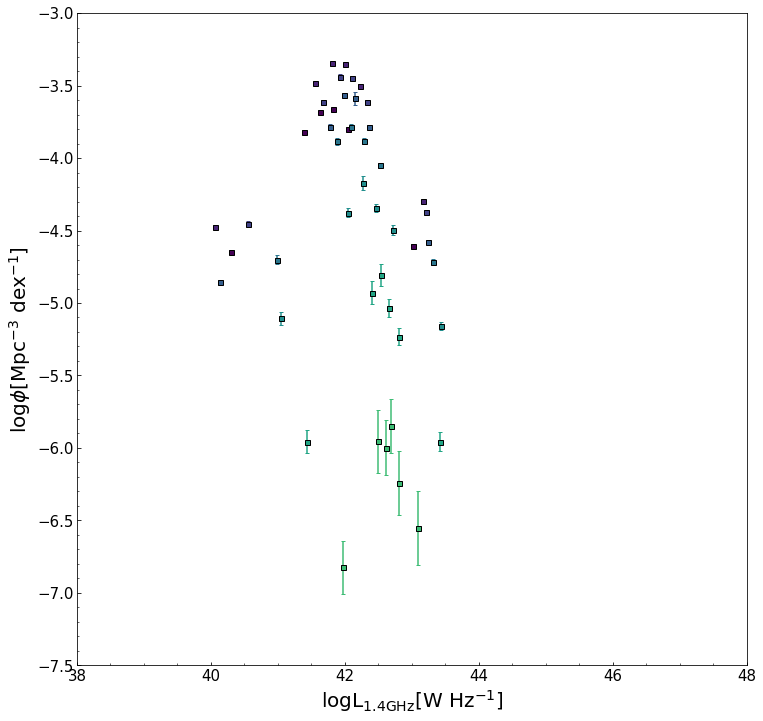

In [50]:
nx, ny = 3, 2
LFfig = plt.figure(figsize=(12,12))
colors = cm.viridis.colors
# Initialize subplot
ax = plt.subplot(111)
for idx_column, (xcolumn, ycolumn, err_ycolumn) in enumerate(zip(lbin_center_df.iteritems(), logLF_df.iteritems(), elogLF_df.iteritems())):
    z_med = list_z_med[idx_column]
    # My LF points
    ax.errorbar(xcolumn[1].values, ycolumn[1].values, err_ycolumn[1].values, \
                    fmt = 's', ms = 5, ecolor = colors[25*idx_column], color = colors[25*idx_column], capsize = 2, mec = 'k', mew = 1, zorder = 3)
# Plot limit
ax.set_xlim(38, 48), ax.set_ylim(-7.5, -3)
# Plot stuff
ax.tick_params(axis='both', which='both', direction = 'in', labelsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel(r'$\log {\rm L}_{1.4 {\rm GHz}} [{\rm W}\,\,{\rm Hz}^{-1}]$', size = 20)
ax.set_ylabel(r'$\log \phi [{\rm Mpc}^{-3}\,\,{\rm dex}^{-1}]$', size = 20);
